### 0.
Install pacakges:

```python
pip install aicsimageio
pip install cellpose
```

Download models:

Make sure you are running this notebook with access to a GPU. If you don't have access, set the parameter gpu=False (below), but be warned that running model inference will take much longer.

In [1]:
#### ADD CUSTOM PATH ###
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant'

In [2]:
import sys
sys.path.append(path_to_quant)

In [3]:
from confocalQuant.segmentation import toggle_filters, load_3D, int_to_float
from aicsimageio import AICSImage
from cellpose import models

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


### 1.
First, specify which channels to load from the image listed in path. You can specify as many channels as you want. Takes .czi files as input.

In [33]:
# specify channels to load
channels = [0,1,2] #### ADD CUSTOM CHANNELS ####

# specify path
path = '../../data/neuronbatch10132023_mitohealth/B06-1.czi' #### ADD CUSTOM PATH ####

### 2.
Visualize the image by toggling through the different parameters:

- *show*: select which channels you want to show. Hold shift to select multiple channels at once. A maximum of 3 channels can be selected at once. Channels will be shown as Red, Green, Blue in ascending order. To modify this, change the order in which you load the channels above. 
- *adjust*: toggle which images to adjust with sliders below
- *zi_slider*: toggle through images on the z-axis
- *gamma_slider*: apply gamma filter for visualization. 
- *median slider*: apply median filter to remove sensor noise
- *background slider*: subtract background signal from all values (in %).
- *lower_slider*: set values below this threshold to 0 (in %).
- *upper_slider*: set values above this threshold to max value (in %).

N.B. The first time you call the function toggle_filters will take longer than subsequent rounds, as some of the code gets compiled into machine code first, to substantially speed up the functions in subsequent calls.

In [34]:
# load image
img = AICSImage(path)
out = load_3D(img, channels)
out_float = int_to_float(out)

# visualize the image
toggle, median, background_dict, gamma_dict, upper_dict, lower_dict = toggle_filters(out_float)
toggle

### 3.
Choose parameters above that remove background signal (from tissue autofluorescence or contaminating cells), smooth over sensor noise if present, remove outlier signal and highlight the cells you care about segmenting. However, don't go overboard with thesholding, otherwise the model will have trouble. Only the channels you will actually be using in the model should be adjusted in this way (i.e. a cell body marker and, optionally, a nuclear marker).

In [ ]:
### MODIFY BASED ON SETTINGS ABOVE ###
kernel = 1 # (i.e. median filter value)
background_dict = {0: 0, 1: 95, 2: 0.0} # (i.e. for every channel, background value)
gamma_dict =  {0: 1, 1: 1, 2: 1} # (i.e. for every channel, the gamma value)
lower_dict = {0: 0, 1: 0, 2: 0} # (i.e. for every channel, the lower value)
upper_dict =  {0: 100, 1: 99.5, 2: 100} # (i.e. for every channel, the upper value)

In [ ]:
# apply the filters
out_med = run_med_filter(out_float, kernel = kernel)
out_float_subtract = bgrnd_subtract(out_med, np.array(list(background_dict.values())))
g_correct = gamma_correct_image(out_float_subtract,  gamma_dict, lower_dict, upper_dict)

### 4.

Perform model segmentation. Start with the default parameters, then go back to modify them once you've viewed initial results. 

In [ ]:
### MODEL PARAMS ###

diameter=17 # expected cell body diameter in um
channels=[2,0] # channels to use for segmentation. 1=red, 2=green, 3=blue; see the image above to determine what colors you care about. First position = cell body channel. Second position = nuclear channel. If you don't want to use a nuclear channel for segmentation, enter '0' in the second position.
min_size=500 # minimum number of expected points ("voxels") per cell

In [ ]:
# get anisotropy
anisotropy = get_anisotropy(img)
print('Anisotropy: ' + str(anisotropy))

# load model
model = models.Cellpose(gpu = True, model_type='cyto2')

# run inference
masks, flows = do_inference(g_correct, do_3D=True, model=model, anisotropy=anisotropy, diameter=diameter, channels=channels, channel_axis=3, z_axis=0, min_size=min_size, normalize = False)

### 5. 
Toggle through the segmentation results to evaluate them.

In [ ]:
# toggle through segmentation
extracted = extract_channels([0,1], g_correct) # enter which channels to show here (up to 3 channels)
toggle_segmentation(float_to_int(extracted), masks) # you can optionally pass out_float, out_med, out_float_subtract, or apply different filters to out_float to help with the visualization

### 6. 
You may want to repeat steps 1-5 to make sure the parameters you are choosing work well for different images.
Once you've found good parameters, modify the example.sbatch file to do inference on all your images.

```bash
sbatch example.sbatch
```

### 7. 

Load, explore, and plot quantifications of the results.

In [3]:
from confocalQuant.segmentation import extract_sbatch_parameters, get_czi_files, impose_segmentation, toggle_filters
from confocalQuant.plotting import return_results, concatenate_Y, add_metadata, exclude_files, modify_keep_files

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [4]:
#### SPECIFY PATH TO SBATCH FILE ###
path_to_sbatch_file = './run_jobs_mitohealthNeuN_1018.sbatch'
path_to_czi_files = '../../data/neuronbatch101823_mitohealth/'
nuclear_col_idx = 0
soma_col_idx = 1
nuclear_percentile = 20 
soma_percentile = 20
colnames = ['DAPI', 'NeuN', 'mito', 'mito-b', 'ID']
path_to_meta = './temp (1).csv'

In [5]:
# load & concatenate the data
mat, masks, Y, Ncells, Nzi, cells_per_job, zi_per_job = return_results(path_to_sbatch_file)
all_file_names = get_czi_files(path_to_czi_files)
data = concatenate_Y(all_file_names, Y, cells_per_job, Ncells, nuclear_col_idx, soma_col_idx, nuclear_percentile, soma_percentile, colnames)
add_metadata(data, path_to_meta)

In [7]:
# toggle segmentation
ID = 12 #### UPDATE IMAGE ID ####
sdata = impose_segmentation(ID, zi_per_job, Nzi, mat, masks)
toggle, median, background_dict, gamma_dict, upper_dict, lower_dict = toggle_filters(sdata)
toggle

In [18]:
# exclude files from quantification and segmentation toggling (optional)
keep_files = exclude_files(exclude, all_file_names)

# if there are none to remove, run
#keep_files = list(range(len(all_file_names)))

In [ ]:
#### SPECIFY IDS TO REMOVE ####
ids_to_remove = []

# remove IDs from keep_files if you think it's necessary based on poor segmentation or image quality (otherwise re-run with differnet parameters)
keep_files = modify_keep_files(keep_files, ids_to_remove)

In [ ]:
# modify data to only include the keep_files IDs
data = data[[x in keep_files for x in data['ID']]]

In [ ]:
# plot effects
plot_effect(data, 'condition', 'G2 vehicle', 'G2 CDP-choline', 'mito-b')

In [ ]:
# mixed model quantification

### 8.
Representative images.

In [107]:
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels, impose_segmentation, float_to_int
#from confocalQuant.plotting import add_scale_bar, add_inset, plot_axis, get_id_data, get_mean_projections, compute_avs, get_rep_im
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage


In [384]:
dict_treat = dict(zip(data['filename'], data['treatment']))
dict_line = dict(zip(data['filename'], data['line']))

mean_per_filename, mean_per_condition = compute_avs(data, 'filename', 'treatment', 'line', 'mito-b')
treat_rep = get_rep_im('rosiglitazone', 'Y622', all_file_names, mean_per_condition, mean_per_filename, dict_treat, dict_line)
vehicle_rep = get_rep_im('vehicle', 'Y622', all_file_names, mean_per_condition, mean_per_filename, dict_treat, dict_line)

In [377]:
np.unique(data['treatment'])

array(['CDP-choline', 'GW501516', 'rosiglitazone',
       'sn-glycero-3-phosphocholine', 'vehicle'], dtype=object)

In [385]:
collabs = ['NeuN','NeuN+DAPI',  'NeuN Mask', 'Mitohealth']
rowlabs = ['Y622 + vehicle', 'Y622 + Rosi']

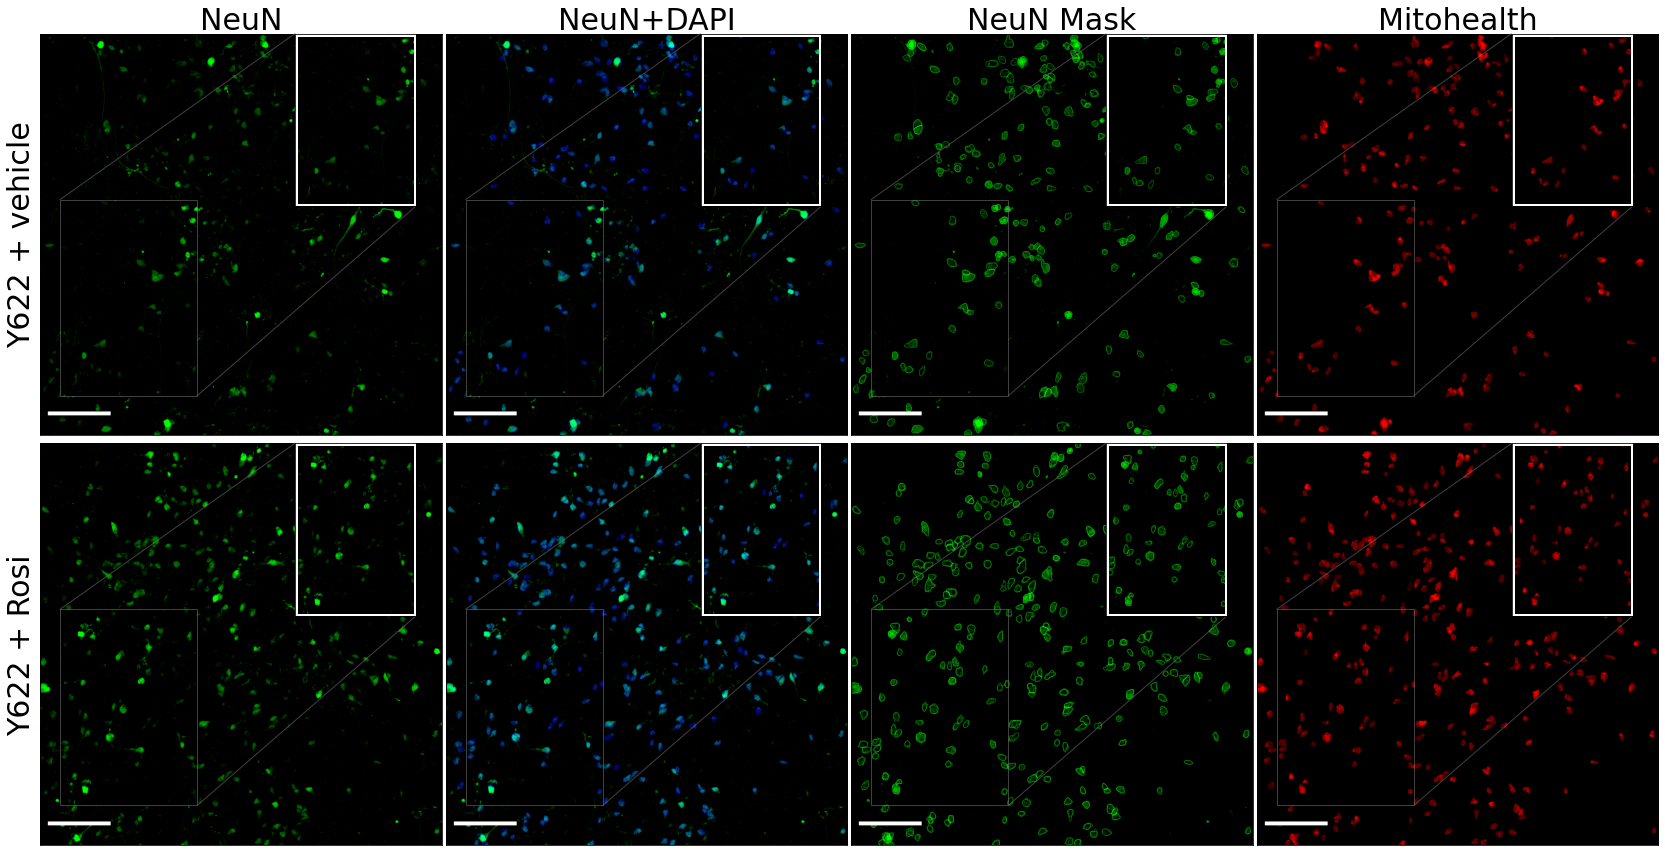

In [400]:
# get data for a specific ID
conditions = [vehicle_rep, treat_rep]
fig, axes = plt.subplots(2, 4, figsize=(29, 15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust the spacing

for i in range(len(conditions)):
    ID = conditions[i]
    mat_sele, mask_sele = get_id_data(ID, zi_per_job, Nzi, mat, masks)

    # make plots
    plt0 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99.5, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[1,0], order=[2,1,0], mask_channel = [0], maskit=True)
    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .9}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 100, 2: 99.9}, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True)
    d = impose_segmentation(ID, zi_per_job, Nzi, mat, masks, val=1)
    plt2 = get_mean_projections(d, mask_sele, background_dict={0: 0, 1: 99, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True)
    plt3 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99.5, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True)

    # get image
    imgA = AICSImage(path_to_czi_files + all_file_names[ID])

    # show plots
    plot_axis(axes, plt3, i,0, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,0, plt3)

    plot_axis(axes, plt2, i,2, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,2, plt2)

    plot_axis(axes, plt0, i,1, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,1, plt0)

    plot_axis(axes, plt1, i,3, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,3, plt1)
    


fig.savefig('test.png')


In [ ]:
# run segmentation on a few images to tune params --> then run on all

# need to also plot hists to show NeuN and DAPI dist by image - no effects explained by image
# and if so it probably makes more sense to pick the top x percent NeuN where x is computed on all images, so really getting neurons;
# can update the masks with the NeuN / DAPI cutoffs and then toggle again --> toggle through all segmentations and pick the ones to exclude for final analysis
# also use this toggling to select the NeuN / DAPI cutoffs

# print how much the magnification is in upper right corner
# only show masks that pass the NeuN + DAPI cutoff in the rep images
# add thresholding across two images so that comparable (upper=99.9%)

In [14]:
#### below is scrap